In [1]:
%matplotlib inline
from mplfonts.bin.cli import init
init()
from mplfonts import use_font
use_font('SimHei')
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
plt.style.use('fivethirtyeight')
import pandas as pd
import numpy as np

adult = pd.read_csv("adult_with_pii.csv")
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)
def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0


# 稀疏向量技术

```{admonition} 学习目标
阅读本章后，您将能够：
- 描述稀疏向量技术，以及使用此技术的原因
- 定义和实现"高于阈值"算法
- 在迭代算法中应用稀疏向量技术
```

我们已经学习了一个很有代表性的机制：指数机制。指数机制通过隐瞒一部分信息来获得低于预期的隐私消耗量。还有其他类似的方法吗？

当然还有类似的方法：*稀疏向量技术*（Sparse Vector Technique，SVT）{cite}`dwork2009A`。实际应用已证明稀疏向量技术可以非常有效地节省隐私消耗量。稀疏向量技术适用于在数据集上执行敏感度为1的问询流。此技术只发布问询流中第一个通过测试的问询*索引号*，而不发布其他任何信息。稀疏向量技术的优势在于，*无论总共收到了多少问询*，此机制消耗的总隐私消耗量都是固定的。

## 高于阈值算法

稀疏向量技术最基础的实例是`AboveThreshold`（高于阈值）算法（详见[Dwork和Roth](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf) {cite}`dwork2014`论文中的算法1）。算法输入是敏感度为1的问询流、数据集$D$阈值$T$、以及隐私参数$\epsilon$；算法满足$\epsilon$-差分隐私。算法的Python实现如下所述。


In [2]:
# 满足ε-差分隐私
def above_threshold(queries, df, T, epsilon):
    T_hat = T + np.random.laplace(loc=0, scale = 2/epsilon)
    
    for idx, q in enumerate(queries):
        nu_i = np.random.laplace(loc=0, scale = 4/epsilon)
        if q(df) + nu_i >= T_hat:
            return idx
    return None # 返回一个无效的问询索引号

`AboveThreshold`（近似）返回`queries`中回复结果超过阈值的第一个问询所对应的索引号。算法之所以满足差分隐私，是因为算法有可能返回*错误的*索引号，索引号对应的问询回复结果有可能未超过给定阈值，索引号对应的问询有可能不是第一个回复结果超过阈值的问询。

算法的工作原理如下。首先，算法生成一个*噪声阈值*`T_hat`；随后，算法比较噪声问询回复（`q(i) + nu_i`）与噪声阈值；最后，算法返回第一个噪声问询回复大于噪声阈值的问询索引号。

尽管此机制会计算*多个*问询的回复结果，但该算法的隐私消耗量仅为$\epsilon$。这个结论或多或少会令人感到惊讶。与之对比，该算法一种可能的朴素实现方法是，先计算所有问询的噪声回复结果，再选择高于阈值的第一个问询索引号：

In [3]:
# 满足|queries|*ε-差分隐私
def naive_above_threshold(queries, df, T, epsilon):
    for idx, q in enumerate(queries):
        nu_i = np.random.laplace(loc=0, scale = 1/epsilon)
        if q(df) + nu_i >= T:
            return idx
    return None

当问询总数量为$n$时，根据串行组合性，该朴素实现可以满足$n\epsilon$-差分隐私。

为什么`AboveThreshold`的效果会如此好呢？正如我们在指数机制中所看到的那样，串行组合性允许`AboveThreshold`发布比实际所需*更多的信息*。特别地，该算法的朴素实现允许发布每一个（而不仅仅是第一个）超过阈值的问询索引号，也允许*额外*发布噪声问询回复本身。即便额外发布了这么多信息，朴素实现依然可以满足$n\epsilon$-差分隐私。`AboveThreshold`可以隐瞒所有这些额外的信息，从而得到更加紧致的隐私消耗量。

## 应用稀疏向量技术

当我们想执行很多不同的问询，但我们只关心其中一个问询（或一小部分问询）的回复结果时，稀疏向量技术就有很大的用武之地了。实际上，之所以叫稀疏向量技术，正是因为此技术的适用场景：问询*向量*越*稀疏*（即大多数回复结果不会超过阈值），此技术作用最大。

在前面提到的场景中，我们已经有了一个完美的适用场景：选择求和问询的裁剪边界。之前，我们实现的方法类似于`AboveThreshold`的朴素实现：获得多个不同的裁剪边界后，分别计算噪声裁剪边界，并选择一个尽可能低的，且不会导致最终回复结果改变太大的一个裁剪边界。

我们可以通过使用稀疏向量技术获得更好的效果。考虑这样一个问询：此问询首先对数据集中每个人的年龄进行裁剪，再把裁剪结果求和：

In [5]:
def age_sum_query(df, b):
    return df['Age'].clip(lower=0, upper=b).sum()

age_sum_query(adult, 30)

913809

我们想选择一个较好的`b`。朴素算法是获取多个满足差分隐私的`b`，返回使求和结果不再增大的最小的`b`。

In [6]:
def naive_select_b(query, df, epsilon):
    bs = range(1, 1000, 10)
    best = 0
    threshold = 10
    epsilon_i = epsilon / len(bs)
    
    for b in bs:
        r = laplace_mech(query(df, b), b, epsilon_i)
        
        # 如果新的求和结果与旧的求和结果很接近，则停止
        if r - best <= threshold:
            return b
        # 否则，将"最佳"求和结果更新为当前求和结果
        else:
            best = r
        
    return bs[-1]

naive_select_b(age_sum_query, adult, 1)

81

我们可以在这里使用稀疏向量技术吗？我们只关心一件事：当`age_sum_query(df, b)`停止增加时`b`的值。然而，`age_sum_query(df, b)`的敏感度就等于`b`，因为增加或移除`df`中的一列会至多使求和结果改变`b`；要想使用稀疏向量技术，我们需要构建敏感度为1的问询流。

实际上，我们真正关心的是求和结果在特定$b$的取值下是否会*变化*（即`age_sum_query(df, b) - age_sum_query(df, b + 1)`是否足够小）。考虑一下，如果我们向`df`增加一行数据会发生什么：问询中第一部分`age_sum_query(df, b)`的结果会增加$b$，但问询中第二部分`age_sum_query(df, b + 1)`的结果*也*会增加，只不过增加了$b + 1$。因此，敏感度实际上为$\vert b - (b + 1) \vert = 1$。这意味着此问询的敏感度为1，满足要求！随着$b$的值趋近于最优值，问询中两部分的差值将趋近于0：

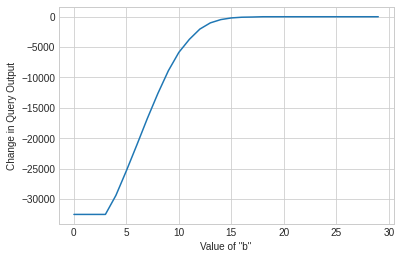

In [7]:
bs = range(1,150,5)
query_results = [age_sum_query(adult, b) - age_sum_query(adult, b + 1) for b in bs]
plt.xlabel('"b"的值')
plt.ylabel('问询输出变化')
plt.plot(query_results);

根据这一观察结论，我们来定义一个求和差问询流，并基于稀疏向量技术，应用`AboveThreshold`确定最佳`b`的问询索引号。

In [9]:
def create_query(b):
    return lambda df: age_sum_query(df, b) - age_sum_query(df, b + 1)

bs = range(1,150,5)
queries = [create_query(b) for b in bs]
epsilon = .1

bs[above_threshold(queries, adult, 0, epsilon)]

91

请注意，备选`b`的列表有多长*并不重要*。无论此列表有多长，我们都能获得准确的结果（并消耗相同的隐私预算）。稀疏向量技术真正的强大之处在于，其消除了隐私消耗量与所执行问询数量的依赖关系。尝试改变上述`b`的备选范围后重新运行此机制，可以得到下图。我们可以看到，机制的输出结果不依赖于`b`的数量。即使备选`b`的列表中包含*上千个*元素，我们仍将得到准确的结果！

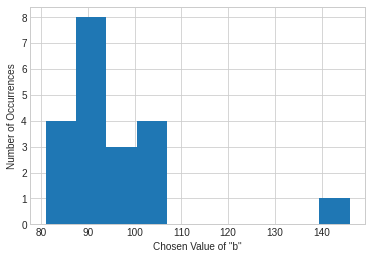

In [10]:
plt.xlabel('备选"b"的值')
plt.ylabel('出现次数')
plt.hist([bs[above_threshold(queries, adult, 0, epsilon)] for i in range(20)]);

我们可以使用稀疏向量技术构建可自动计算裁剪参数的求和问询算法（也可以构建对应的均值问询算法）。

In [118]:
def auto_avg(df, epsilon):
    def create_query(b):
        return lambda df: df.clip(lower=0, upper=b).sum() - df.clip(lower=0, upper=b+1).sum()

    # 构造问询流
    bs = range(1,150000,5)
    queries = [create_query(b) for b in bs]
    
    # 使用1/3的隐私预算执行AboveThreshold，得到一个好的裁剪参数
    epsilon_svt = epsilon / 3
    final_b = bs[above_threshold(queries, df, 0, epsilon_svt)]

    # 分别使用1/3的隐私预算来获得噪声求和值与噪声计数值
    epsilon_sum = epsilon / 3
    epsilon_count = epsilon / 3
    
    noisy_sum = laplace_mech(df.clip(lower=0, upper=final_b).sum(), final_b, epsilon_sum)
    noisy_count = laplace_mech(len(df), 1, epsilon_count)
    
    return noisy_sum/noisy_count

auto_avg(adult['Age'], 1)

38.5750654706846

该算法调用了三个差分隐私机制：一次`AboveThreshold`，两次拉普拉斯机制，每个机制消耗$\frac{1}{3}$的隐私预算。根据串行组合性，此算法满足$\epsilon$-差分隐私。由于我们可自由测试`b`更大可能的取值范围，因此我们能够对不同尺度的数据使用相同的`auto_avg`函数！例如，我们也可以在资本收益列上使用`auto_avg`函数。要知道，资本收益列的数据尺度与年龄列有很大的区别。

In [120]:
auto_avg(adult['Capital Gain'], 1)

1068.1445048412666

请注意，这需要运行非常长的时间！因为资本收益列的尺度要大得多，我们需要尝试非常多的`b`值才能找到最好的那一个。我们可以通过增加步长（我们的实现代码使用的步长是5）或利用指数尺度来构建`b`的列表，以节省计算开销。

## 返回多个问询结果

在上述应用场景中，我们只需要得到*第一个*超过阈值的问询索引号。但在其他的一些应用场景中，我们可能想要找到*所有*超过阈值的问询索引号。

我们也可以使用稀疏向量技术实现这一点，但代价是我们必须消耗更高的隐私预算。我们可以实现`sparse`（稀疏）算法（详见[Dwork和Roth论文](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf) {cite}`dwork2014`中的算法2）来完成该任务。实现方法非常简单：

1. 从问询流$qs = \{q_1, \dots, q_k\}$开始
2. 在问询流$qs$上执行`AboveThreshold`，得到*第一个*超过阈值的问询索引号$i$
3. 使用$qs = \{q_{i+1}, \dots, q_k\}$（即问询流的剩余部分）重启算法（转到步骤(1)）

如果算法调用$n$次`AboveThreshold`，每次调用的隐私参数为$\epsilon$，则根据串行组合性，此算法满足$n\epsilon$-差分隐私。如果想在给定的总隐私消耗量下执行算法，我们就需要限制$n$的大小。也就是说，`sparse`算法可以要求分析者最多调用$c$次`AboveThreshold`。

In [206]:
def sparse(queries, df, c, T, epsilon):
    idxs = []
    pos = 0
    epsilon_i = epsilon / c
    
    # 如果我们执行完问询流中的所有问询，或者我们找到了c个超过阈值的问询回复，则停止
    while pos < len(queries) and len(idxs) < c:
        # 执行AboveThreshold，寻找下一个超过阈值的问询回复
        next_idx = above_threshold(queries[pos:], df, T, epsilon_i)
        
        # 如果AboveThreshold执行完了最后一个问询，则返回所有超过阈值的问询索引号
        if next_idx == -1:
            return idxs
        
        # 否则，更新pos，使其指向问询流中剩余的问询
        pos = next_idx+pos
        # 更新idxs，添加AboveThreshold找到的问询索引号
        idxs.append(pos)
        # 移动到问询流中的下一个问询
        pos = pos + 1

    return idxs

In [207]:
epsilon = 1
sparse(queries, adult, 3, 0, epsilon)

[19, 22, 23]

根据串行组合性，`sparse`算法满足$\epsilon$-差分隐私（每次消耗$\epsilon_i = \frac{\epsilon}{c}$的隐私预算来调用`AboveThreshold`）。在Dwork和Roth的算法描述中，每次调用`AboveThreshold`都将消耗相应的隐私预算$\epsilon_i$。他们进一步使用高级组合性，使总隐私消耗量为$\epsilon$（也可以在此使用零集中差分隐私或瑞丽差分隐私的组合性）。

## 应用：范围问询

*范围问询*（Range Query）要问的是："数据集中有多少行的值落在范围$(a, b)$中？"范围问询是一种计数问询，因此其敏感度为1；我们不能对一组范围问询使用并行组合性，因为满足相应问询条件的数据行可能会有重叠。

考虑一组针对年龄列的范围问询（即问询形式为"有多少人的年龄在$a$和$b$之间？"）。我们可以随机生成很多这样的问询：

In [219]:
def age_range_query(df, lower, upper):
    df1 = df[df['Age'] > lower]
    return len(df1[df1['Age'] < upper])

def create_age_range_query():
    lower = np.random.randint(30, 50)
    upper = np.random.randint(lower, 70)
    return lambda df: age_range_query(df, lower, upper)


range_queries = [create_age_range_query() for i in range(10)]
results = [q(adult) for q in range_queries]
results

[6163, 1602, 3967, 3745, 14271, 898, 0, 808, 6657, 17655]

这些范围问询的回复结果可能相差甚远。部分问询范围可能只会匹配上很少的数据行（甚至匹配不上任何数据行），对应的计数值很小。然而，另一部分问询范围可能会匹配上大量的数据行，对应的计数值很大。在多数情况下，我们知道小计数值的差分隐私回复结果会很不准确，得到这些问询结果的实际意义不大。我们想要做的是了解哪些问询的结果是有价值的，并*仅为*这些有价值的问询结果支付隐私预算。

我们可以使用稀疏向量技术实现这一点。首先，我们确定一个阈值，并得到范围问询流中回复结果超过此阈值的问询索引号。我们认为这些问询都是"有价值的"问询。随后，我们应用拉普拉斯机制得到这些有价值问询的差分隐私回复结果。这样一来，总隐私开销与超过阈值的问询数量成正比，而非与总问询数量成正比。如果我们预计只有少数问询的回复结果会超过阈值，则所需的总隐私开销会小得多。

In [208]:
def range_query_svt(queries, df, c, T, epsilon):
    # 首先，执行sparse，得到"有价值的"问询
    sparse_epsilon = epsilon / 2
    indices = sparse(queries, adult, c, T, sparse_epsilon)
    
    # 所有，为每个"有价值的"问询执行拉普拉斯机制
    laplace_epsilon = epsilon / (2*c)
    results = [laplace_mech(queries[i](df), 1, laplace_epsilon) for i in indices]
    return results

In [222]:
range_query_svt(range_queries, adult, 5, 10000, 1)

[14272.137097167237, 17697.903735723932]

此算法实现中，我们使用一半的隐私预算来确定高于阈值10000的前$c$个问询，另一半隐私预算则用于获取这些问询的噪声回复结果。如果高于阈值的问询数量远小于总问询数量，使用此方法就可以获得更准确的回复结果。